In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver
from filterpy.common import Q_discrete_white_noise
%matplotlib inline
%matplotlib widget

In [8]:
# ******************** Data from Admittance Control ***************** ##
#df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_Admittance/admittance.csv") 

# ******************** Data from Admittance Control ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_Admittance/admittance.csv") 

## ******************** Data from Candle Position ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_candle/candle.csv") 

# # ******************** Data from HP ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_HP/HP.csv") 

# ******************** Data from Velocity control ***************** ##
df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_VelControl/velctrl.csv") 

# ******************** Data from angular position control ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_link2/link2.csv") 

time = df['__time']
time =  (time.values - time.values[0])

### Data from testing only joint 2 (90 degrees, 180 etc)#######################################
q1 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q1/position'].fillna(method='ffill')
q2 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q2/position'].fillna(method='ffill')
q3 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q3/position'].fillna(method='ffill')
q4 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q4/position'].fillna(method='ffill')
q5 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q5/position'].fillna(method='ffill')
q6 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q6/position'].fillna(method='ffill')

qdot1 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q1/velocity'].fillna(method='ffill')
qdot2 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q2/velocity'].fillna(method='ffill')
qdot3 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q3/velocity'].fillna(method='ffill')
qdot4 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q4/velocity'].fillna(method='ffill')
qdot5 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q5/velocity'].fillna(method='ffill')
qdot6 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q6/velocity'].fillna(method='ffill')

# q1_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud1/position'].fillna(method='ffill')
# q2_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud2/position'].fillna(method='ffill')
# q3_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud3/position'].fillna(method='ffill')
# q4_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud4/position'].fillna(method='ffill')
# q5_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud5/position'].fillna(method='ffill')
# q6_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud6/position'].fillna(method='ffill')

# qdot1_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud1/velocity'].fillna(method='ffill')
# qdot2_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud2/velocity'].fillna(method='ffill')
# qdot3_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud3/velocity'].fillna(method='ffill')
# qdot4_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud4/velocity'].fillna(method='ffill')
# qdot5_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud5/velocity'].fillna(method='ffill')
# qdot6_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud6/velocity'].fillna(method='ffill')
## *******************************************************************************************###

In [ ]:
# def kalman_filter(x0,R1,R2,Q1,Q2):
#     kf = KalmanFilter(dim_x=2, dim_z=2)    
#     dt=0.001
#     kf.x = x0
#     kf.P *= np.array([[1000, 0], [0, 1000]])
#     kf.R= np.array([[R1, 0.],[0.,  R2]])
#     kf.Q = np.array([[Q1, 0.],[0., Q2]])
#     kf.F = np.array([[1., dt],[0., 1]])
#     kf.H =  np.array([[1., 0.],[0.,  1.]])
#     return kf

In [38]:
# def kalman_evolution(kf, q,qdot):
#     xs = []
#     z = np.array([q1.values, qdot1.values])
#     #z.astype(np.float64,casting="unsafe")
#     for i in range(len(time)):
# #         xs = z[:,i]
#         kf.predict()
#         kf.update(z[:,i])
#         xs.append(kf.x)
#     xs = np.array(xs)

In [4]:
def state_observer(x_hat, z, dt, l1, l2):
    ys = []
    A = np.array([[1., dt],
             [0., 1.]])

    L = np.array([l1, l2])

    C = np.array([1., 0.])
    B = np.array([0, 0.])
    for i in range(len(time)):
        x_hat = A@x_hat + L*(z[i] - C@x_hat)*dt
        ys.append(x_hat)
    ys = np.array(ys)
    return ys

In [5]:
def plot_states(q,qdot, kal, So, label, label2):
    fig, ax = plt.subplots()
    ax = plt.subplot(211)
    plt.plot(qdot.values,'r')
    plt.plot(kal[:,1], '--b')
    plt.plot(So[:,1], ':k')
    #ax.set_ylim(-0.1, 0.1)
    ax.set_ylabel(r"$[deg/s]$", fontsize = 10)
    ax.legend((label[0], label[1], label[2]),loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.grid(True)

    ax = plt.subplot(212)
    plt.plot(q.values,'r')
    plt.plot(kal[:,0], '--b')
    plt.plot(So[:,0], ':k')
    #ax.set_ylim(175, 185)
    ax.set_ylabel(r"$[deg]$", fontsize = 10)
    ax.legend((label2[0], label2[1], label2[2]),loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.grid(True)
    return fig

In [6]:
q1

0               NaN
1        283.132019
2        283.132019
3        283.132019
4        283.132019
            ...    
29985    -61.787502
29986    -61.787502
29987    -61.787502
29988    -61.787502
29989    -61.787502
Name: /jaco/manipulator_skillset/manipulator_skillset/joint/q1/position, Length: 29990, dtype: float64

In [1]:
for i in range(len(time)):
    if np.isnan(q1[i]):
        q1[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot1[i]):
        qdot1[i] = 0
        
x0 = np.array([180, 0.]).T
R1 = 0.01
Q1, Q2 = 0.01,1
#kf = kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=1)    
dt=0.01
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R*= R1 
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.]])
xs = []
z = q1.values
l1, l2 = 28.2, 200
y1 = state_observer(x0,z,dt,l1, l2)
y1[:,1] = y1[:,1]*2
for i in range(len(time)):
    kf.predict()
    kf.update(z[i])
    xs.append(kf.x)
xs = np.array(xs)
xs[:,1] = xs[:,1]*2
label1 = [r"$\dot{q}_1$",r"$\dot{\hat{q}}_{1_k}$",r"$\dot{\tilde{q}}_{1_{so}}$"]
label2 = [r"$q_1$",r"$\hat{q}_{1_k}$",r"$\tilde{q}_{1_{so}}$"]
fig = plot_states(q1,qdot1, xs, y1, label1, label2)
# image_format = 'svg' # e.g .png, .svg, etc.
# image_name = 'q1.svg'
# fig.savefig(image_name, format=image_format, dpi=1200)

NameError: name 'time' is not defined

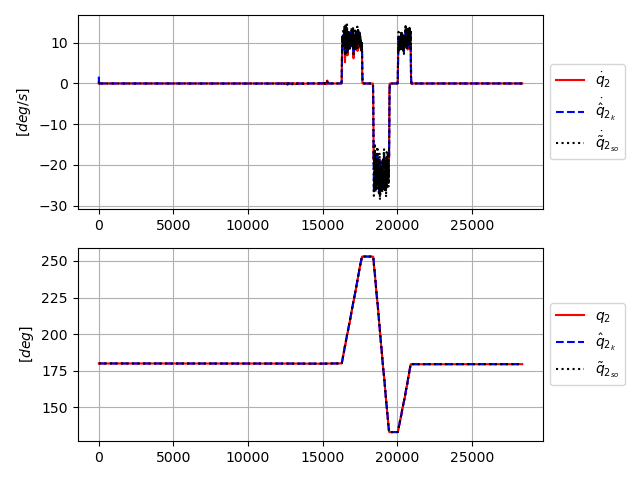

In [40]:
for i in range(len(time)):
    if np.isnan(q2[i]):
        q2[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot2[i]):
        qdot2[i] = 0
        
x0 = np.array([180, 0.]).T
R1 = 1
Q1, Q2 = 0.01, 1
#kf = kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=1)    
dt=0.01
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R*= R1 
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.]])
xs2 = []
z = q2.values
l1, l2 = 28.2, 200
y2 = state_observer(x0,z,dt,l1, l2)
y2[:,1] = y2[:,1]*2
for i in range(len(time)):
    kf.predict()
    kf.update(z[i])
    xs2.append(kf.x)
xs2 = np.array(xs2)
xs2[:,1] = xs2[:,1]*2
label1 = [r"$\dot{q}_2$",r"$\dot{\hat{q}}_{2_k}$",r"$\dot{\tilde{q}}_{2_{so}}$"]
label2 = [r"$q_2$",r"$\hat{q}_{2_k}$",r"$\tilde{q}_{2_{so}}$"]
fig = plot_states(q2,qdot2, xs2, y2, label1, label2)
# image_format = 'svg' # e.g .png, .svg, etc.
# image_name = 'q2.svg'
# fig.savefig(image_name, format=image_format, dpi=1200)

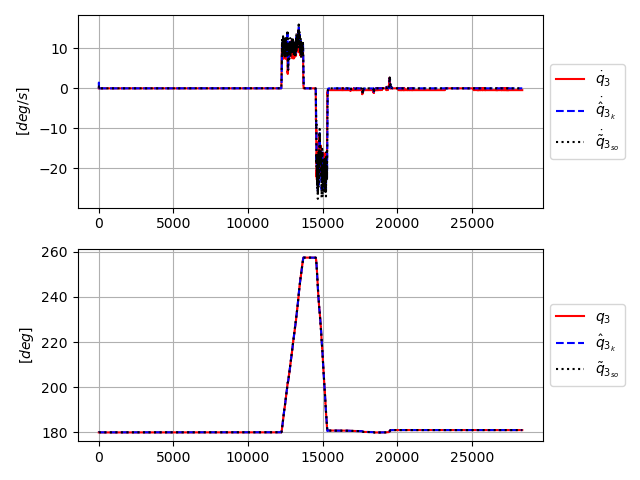

In [41]:
for i in range(len(time)):
    if np.isnan(q3[i]):
        q3[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot3[i]):
        qdot3[i] = 0
x0 = np.array([180, 0.]).T
R1 = 1
Q1, Q2 = 0.01, 1
#kf = kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=1)    
dt=0.01
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R*= R1 
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.]])
xs3 = []
z = q3.values
l1, l2 = 28.2, 200
y3 = state_observer(x0,z,dt,l1, l2)
y3[:,1] = y3[:,1]*2
for i in range(len(time)):
    kf.predict()
    kf.update(z[i])
    xs3.append(kf.x)
xs3 = np.array(xs3)
xs3[:,1] = xs3[:,1]*2
label1 = [r"$\dot{q}_3$",r"$\dot{\hat{q}}_{3_k}$",r"$\dot{\tilde{q}}_{3_{so}}$"]
label2 = [r"$q_3$",r"$\hat{q}_{3_k}$",r"$\tilde{q}_{3_{so}}$"]
fig = plot_states(q3,qdot3, xs3, y3, label1, label2)
# image_format = 'svg' # e.g .png, .svg, etc.
# image_name = 'q3.svg'
# fig.savefig(image_name, format=image_format, dpi=1200)

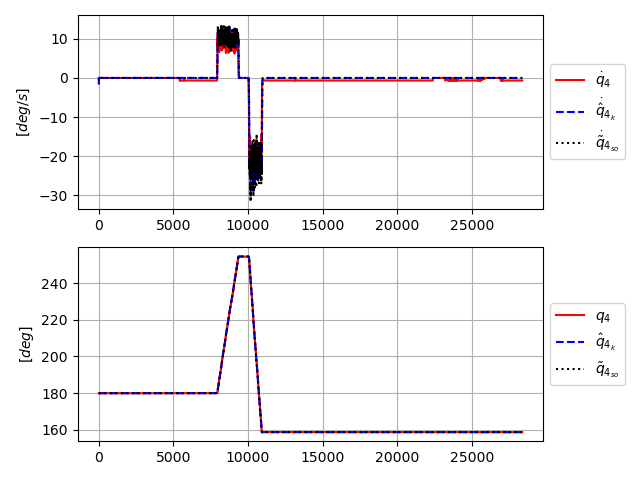

In [42]:
for i in range(len(time)):
    if np.isnan(q4[i]):
        q4[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot4[i]):
        qdot4[i] = 0
x0 = np.array([180, 0.]).T
R1 = 1
Q1, Q2 = 0.01, 1
#kf = kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=1)    
dt=0.01
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R*= R1 
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.]])
xs4 = []
z = q4.values
l1, l2 = 28.2, 200
y4 = state_observer(x0,z,dt,l1, l2)
y4[:,1] = y4[:,1]*2
for i in range(len(time)):
    kf.predict()
    kf.update(z[i])
    xs4.append(kf.x)
xs4 = np.array(xs4)
xs4[:,1] = xs4[:,1]*2
label1 = [r"$\dot{q}_4$",r"$\dot{\hat{q}}_{4_k}$",r"$\dot{\tilde{q}}_{4_{so}}$"]
label2 = [r"$q_4$",r"$\hat{q}_{4_k}$",r"$\tilde{q}_{4_{so}}$"]
fig = plot_states(q4,qdot4, xs4, y4, label1, label2)
# image_format = 'svg' # e.g .png, .svg, etc.
# image_name = 'q4.svg'
# fig.savefig(image_name, format=image_format, dpi=1200)

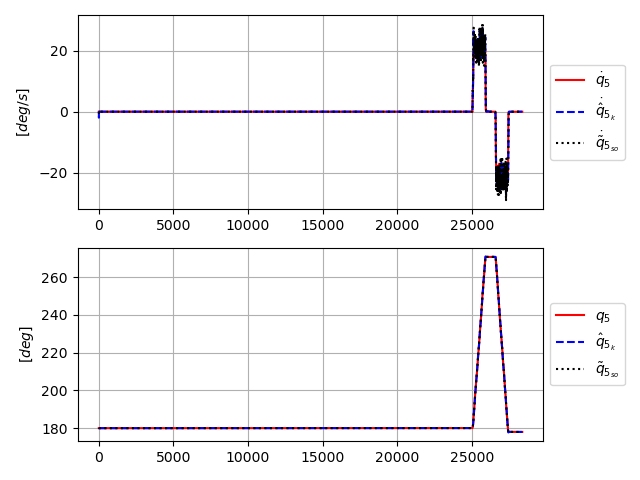

In [43]:
for i in range(len(time)):
    if np.isnan(q5[i]):
        q5[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot5[i]):
        qdot5[i] = 0
R1 = 1
Q1, Q2 = 0.01, 1
#kf = kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=1)    
dt=0.01
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R*= R1 
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.]])
xs5 = []
z = q5.values
l1, l2 = 28.2, 200
y5 = state_observer(x0,z,dt,l1, l2)
y5[:,1] = y5[:,1]*2
for i in range(len(time)):
    kf.predict()
    kf.update(z[i])
    xs5.append(kf.x)
xs5 = np.array(xs5)
xs5[:,1] = xs5[:,1]*2
label1 = [r"$\dot{q}_5$",r"$\dot{\hat{q}}_{5_k}$",r"$\dot{\tilde{q}}_{5_{so}}$"]
label2 = [r"$q_5$",r"$\hat{q}_{5_k}$",r"$\tilde{q}_{5_{so}}$"]
fig = plot_states(q5,qdot5, xs5, y5, label1, label2)
# image_format = 'svg' # e.g .png, .svg, etc.
# image_name = 'q5.svg'
# fig.savefig(image_name, format=image_format, dpi=1200)

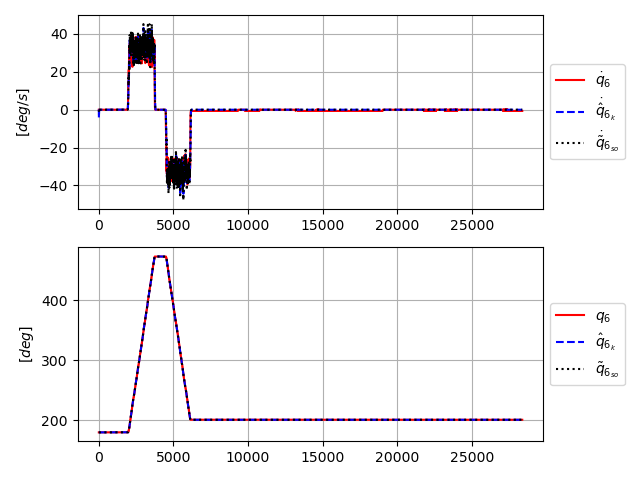

In [44]:
for i in range(len(time)):
    if np.isnan(q6[i]):
        q6[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot6[i]):
        qdot6[i] = 0
x0 = np.array([180, 0.]).T
R1 = 1
Q1, Q2 = 0.01, 1
#kf = kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=1)    
dt=0.01
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R*= R1 
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.]])
xs6 = []
z = q6.values
l1, l2 = 28.2, 200
y6 = state_observer(x0,z,dt,l1, l2)
y6[:,1] = y6[:,1]*2
for i in range(len(time)):
    kf.predict()
    kf.update(z[i])
    xs6.append(kf.x)
xs6 = np.array(xs6)
xs6[:,1] = xs6[:,1]*2
label1 = [r"$\dot{q}_6$",r"$\dot{\hat{q}}_{6_k}$",r"$\dot{\tilde{q}}_{6_{so}}$"]
label2 = [r"$q_6$",r"$\hat{q}_{6_k}$",r"$\tilde{q}_{6_{so}}$"]
fig = plot_states(q6,qdot6, xs6, y6, label1, label2)
# image_format = 'svg' # e.g .png, .svg, etc.
# image_name = 'q6.svg'
# fig.savefig(image_name, format=image_format, dpi=1200)